In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [2]:
#print the list of paths of files in the training set
set_path = 'train'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/train/MHDMa_0.7_Ms_0.5.hdf5', 'data/train/MHDMa_0.7_Ms_0.7.hdf5', 'data/train/MHDMa_0.7_Ms_1.5.hdf5', 'data/train/MHDMa_0.7_Ms_2.hdf5', 'data/train/MHDMa_0.7_Ms_7.hdf5', 'data/train/MHDMa_2_Ms_0.5.hdf5', 'data/train/MHDMa_2_Ms_0.7.hdf5', 'data/train/MHDMa_2_Ms_1.5.hdf5', 'data/train/MHDMa_2_Ms_2.hdf5', 'data/train/MHDMa_2_Ms_7.hdf5']


In [24]:
#select the first path (arbitrary choice)
p = paths[0]
from enum import Enum
class BoundaryCondition(Enum):
    WALL = 0
    OPEN = 1
    PERIODIC = 2

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f['dimensions'].attrs['spatial_dims'])
    print(f["boundary_conditions"].keys())
    bcs = f["boundary_conditions"]
    dim_indices = {
                dim: i for i, dim in enumerate(['x' 'y' 'z'])
            }
    boundary_output = torch.zeros((2,) * 3)
    for bc_name in bcs.keys():
        bc = bcs[bc_name]
        bc_type = bc.attrs["bc_type"].upper()  # Enum is in upper case
        dim = bc.attrs["associated_dims"][0]
        print(dim)
        mask = bc["mask"]
        if mask[0]:
            boundary_output[dim_indices[dim]][0] = BoundaryCondition[
                bc_type
            ].value

['x' 'y' 'z']
<KeysViewHDF5 ['x_periodic', 'y_periodic', 'z_periodic']>
x


KeyError: 'x'

In [12]:
dim_indices = {
                dim: i for i, dim in enumerate(['x' 'y' 'z'])
            }

In [15]:
bcs

<Closed HDF5 group>

In [13]:
import torch
boundary_output = torch.zeros((2,) * 3)
for bc_name in bcs.keys():
    bc = bcs[bc_name]
    bc_type = bc.attrs["bc_type"].upper()  # Enum is in upper case

TypeError: Not a location id (invalid location ID)

In [4]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['x_periodic'].attrs.keys())
    print('get the bc type:', f['boundary_conditions']['x_periodic'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_periodic', 'y_periodic', 'z_periodic']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: periodic


In [5]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['density']>
t1_fields: <KeysViewHDF5 ['magnetic_field', 'velocity']>
t2_fields: <KeysViewHDF5 []>


In [6]:
#The data is of shape (n_trajectories, n_timesteps, x, y, z)
#Get the first t0_field and save it as a numpy array
with h5py.File(p,'r') as f:
    density = f['t0_fields']['density'][:] #HDF5 datasets can be sliced like a numpy array
    print(f'shape of the selected t0_field: ',density.shape)   
    #you can directly slice the selected field without reading the whole dataset by doing:
    #traj = 0 #select the trajectory
    # field = f['t0_fields']['concentration'][traj, :] 

shape of the selected t0_field:  (8, 100, 256, 256, 256)


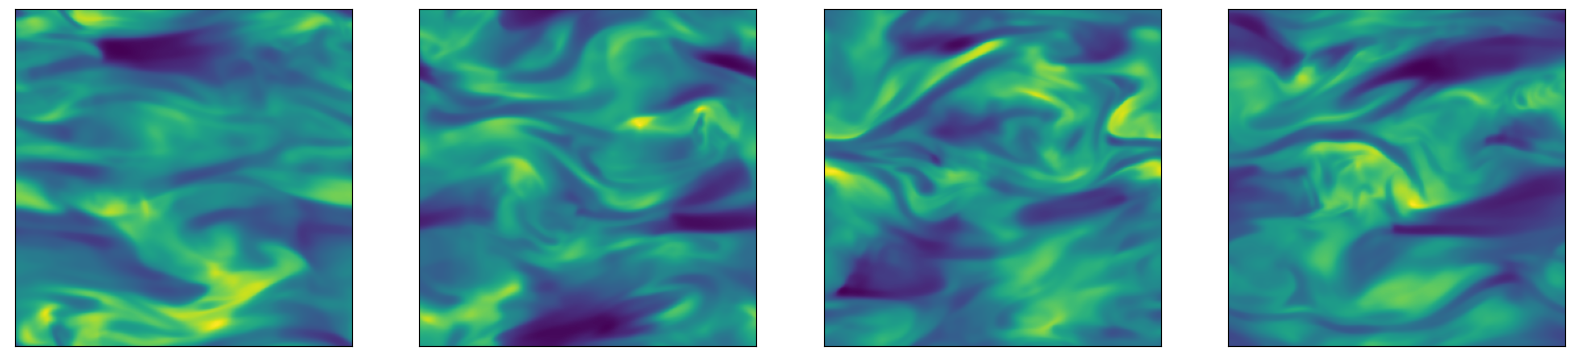

In [16]:
traj = 1 #select the trajectory
x_slice = 128 #selecting the middle slice along the x-axis
traj_toplot = density[traj,:, x_slice,:,:] 
#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = traj_toplot.shape[0]
#fix colorbar for all subplots:
vmin = np.min(traj_toplot)
vmax = np.max(traj_toplot)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
    axs[i].imshow(traj_toplot[t], cmap='viridis', origin='lower')#,norm=norm)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    #axs[i].set_title(f't={t}')



In [17]:
#save figure without axes and titles:

image_name = 'MHD_density_unnormalized'
path_to_save = '/mnt/home/polymathic/ceph/the_well/viz/'
fig.savefig(f'{path_to_save}{image_name}.png', bbox_inches='tight', pad_inches=0.05)

In [20]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
def create_gif(time_series, saving_directory, name_file = 'concentration', delete_imgs=False):
    time_series_min = time_series.min()
    time_series_max = time_series.max()
    if time_series.ndim > 3:
        #error:
        print('Error: The time series should be (time, height, width)')
        return
    if not os.path.exists(saving_directory + '/img_for_gif'):
        os.makedirs(saving_directory + '/img_for_gif')
    images = []
    for i in range(time_series.shape[0]):
        plt.imshow(time_series[i], origin='lower', vmin=time_series_min, vmax=time_series_max);
        #plt.show()
        plt.axis('off')
        plt.savefig(saving_directory + f'/img_for_gif/time_series_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))

    imageio.mimsave(saving_directory + '/' + name_file + '.gif', images, duration=0.1)
    if delete_imgs:
        shutil.rmtree(saving_directory + '/img_for_gif')

In [21]:
create_gif(traj_toplot, 'gif', name_file='density_normalized', delete_imgs=True)

/tmp/ipykernel_3148339/3020939748.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))


In [ ]:
#ADD visu t1,t2 fields